#King County Housing Predicitions


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor


df = pd.read_csv('kc_house_data.csv')

###**Data Cleaning**

Year built range: 1900 - 2015

Price: 75,000 - 7,700,000

In [ ]:
df.drop(['long', 'lat', 'sqft_living15', 'sqft_lot15', 'id'], axis=1, inplace=True)

df = df.dropna()
df.drop(np.where(df['price'] == 0)[0], axis=1, inplace=True)

In [ ]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

#Removing Extreme Values: Keeps prices between 200k - 2m (for handling outliers)
df = df.loc[(df['price'] >= 200000) & (df['price'] <= 2000000)]
print(df.shape)
#new column for logged values
df['logged_price'] = np.log(df['price'])

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
df_IQR = df.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
print(df_IQR.shape)

(20629, 16)
(19681, 17)


<ipython-input-7-4eb68114c4da>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['logged_price'] = np.log(df['price'])


In [ ]:
df['date'] = pd.to_datetime(df['date'])
df['price'] = df['price'].astype(int)
df['floors'] = df['floors'].astype(int)

df['total_sqft'] = df['sqft_above'] + df['sqft_basement']
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['renovation_age'] = np.where(df['yr_renovated'] != 0, df['date'].dt.year - df['yr_renovated'], df['date'].dt.year - df['yr_built'])


df['zipcode'] = df['zipcode'].astype('category')
df['month'] = df['month'].astype('category')

df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,logged_price,total_sqft,year,month,renovation_age
0,2014-10-13,221900,3,1.00,1180,5650,1,0,0,3,...,1180,0,1955,0,98178,12.309982,1180,2014,10,59
1,2014-12-09,538000,3,2.25,2570,7242,2,0,0,3,...,2170,400,1951,1991,98125,13.195614,2570,2014,12,23
3,2014-12-09,604000,4,3.00,1960,5000,1,0,0,5,...,1050,910,1965,0,98136,13.311329,1960,2014,12,49
4,2015-02-18,510000,3,2.00,1680,8080,1,0,0,3,...,1680,0,1987,0,98074,13.142166,1680,2015,2,28
5,2014-05-12,1225000,4,4.50,5420,101930,1,0,0,3,...,3890,1530,2001,0,98053,14.018451,5420,2014,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014-05-21,360000,3,2.50,1530,1131,3,0,0,3,...,1530,0,2009,0,98103,12.793859,1530,2014,5,5
21609,2015-02-23,400000,4,2.50,2310,5813,2,0,0,3,...,2310,0,2014,0,98146,12.899220,2310,2015,2,1
21610,2014-06-23,402101,2,0.75,1020,1350,2,0,0,3,...,1020,0,2009,0,98144,12.904459,1020,2014,6,5
21611,2015-01-16,400000,3,2.50,1600,2388,2,0,0,3,...,1600,0,2004,0,98027,12.899220,1600,2015,1,11


In [ ]:
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['zipcode', 'month']])
df_encoded = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['zipcode', 'month']))
df_encoded = pd.concat([df.reset_index(drop=True), df_encoded], axis=1)
df_encoded = df_encoded.drop(['zipcode', 'month'], axis=1)

df_encoded.shape

(20629, 101)

###**Exploratory Analysis - Derek and Luke**
Original: 21613 rows

IQR: Removes 1146 values from the data set, skew of 0.75

log: Does not remove any data, skew is 0.43, compresses pricing values

Filtered vs Non-Filtered vs Log

Displays the Pricing of houses and comapres with skewing techniques with their skew value

**Figure 1.1**

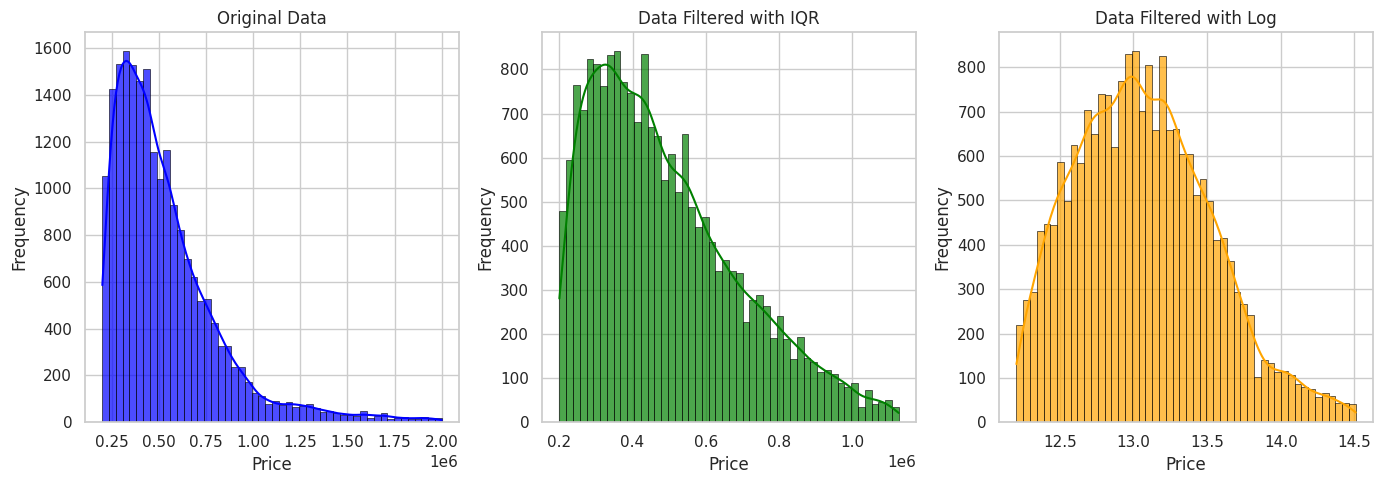

Original Prices Skew:  1.838486961151974   (20629, 21)
IQR Prices Skew:  0.8107638290890004   (19681, 17)
Logged Prices Skew:  0.43446653845484196   (20629, 21)


In [ ]:
sns.set(style="whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

# Plot the original data in the first subplot
sns.histplot(df['price'], color='blue', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax1)
ax1.set_title('Original Data')
ax1.set_xlabel('Price')
ax1.set_ylabel('Frequency')

sns.histplot(df_IQR['price'], color='green', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax2)
ax2.set_title('Data Filtered with IQR')
ax2.set_xlabel('Price')
ax2.set_ylabel('Frequency')

sns.histplot(df['logged_price'], color='orange', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax3)
ax3.set_title('Data Filtered with Log')
ax3.set_xlabel('Price')
ax3.set_ylabel('Frequency')
'''
sns.histplot(df_filtered['price'], color='purple', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax4)
ax3.set_title('Data Filtered with Boolean')
ax3.set_xlabel('Price')
ax3.set_ylabel('Frequency')
'''
plt.tight_layout()
plt.show()

print('Original Prices Skew: ', df['price'].skew(), ' ', df.shape)
print('IQR Prices Skew: ', df_IQR['price'].skew(), ' ', df_IQR.shape)
print('Logged Prices Skew: ', df['logged_price'].skew(), ' ', df.shape)
#print('Boolean Indexing Skew: ', df_filtered['price'].skew(), ' ', df_filtered.shape)

**Figure 1.2**

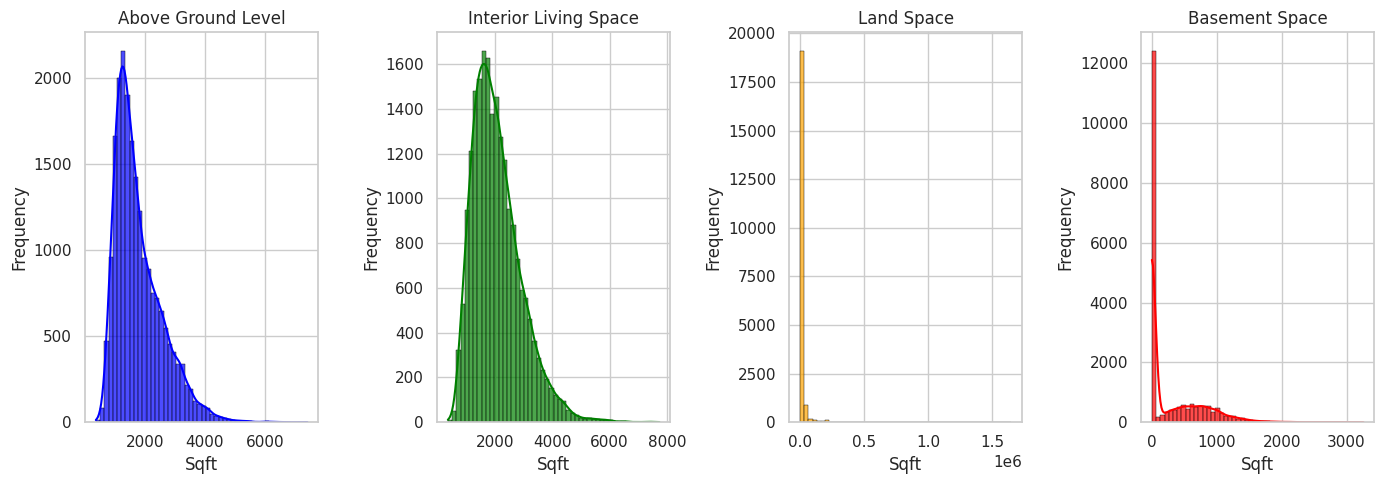

Above Ground Level Skew:  1.2420925910602187 Median:  1580.0
Interior Living Space Skew:  1.088054899922432 Median:  1940.0
Lot Space Skew:  12.600812243400382 Median:  7565.0
Basement Space Skew:  1.4273035573920272 Median:  0.0


In [ ]:
sns.set(style="whitegrid")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 5))

sns.histplot(df['sqft_above'], color='blue', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax1)
ax1.set_title('Above Ground Level')
ax1.set_xlabel('Sqft')
ax1.set_ylabel('Frequency')

sns.histplot(df['sqft_living'], color='green', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax2)
ax2.set_title('Interior Living Space')
ax2.set_xlabel('Sqft')
ax2.set_ylabel('Frequency')

sns.histplot(df['sqft_lot'], color='orange', edgecolor='black', alpha=0.7, bins=50, ax=ax3)
ax3.set_title('Land Space')
ax3.set_xlabel('Sqft')
ax3.set_ylabel('Frequency')

sns.histplot(df['sqft_basement'], color='red', edgecolor='black', alpha=0.7, bins=50, kde=True, ax=ax4)
ax4.set_title('Basement Space')
ax4.set_xlabel('Sqft')
ax4.set_ylabel('Frequency')
plt.tight_layout()

plt.tight_layout()

plt.show()

print("Above Ground Level Skew: ", df['sqft_above'].skew(), "Median: ", df['sqft_above'].median())
print("Interior Living Space Skew: ", df['sqft_living'].skew(), "Median: ", df['sqft_living'].median())
print("Lot Space Skew: ", df['sqft_lot'].skew(), "Median: ", df['sqft_lot'].median())
print("Basement Space Skew: ", df['sqft_basement'].skew(), "Median: ", df['sqft_basement'].median())

**Figure 1.3**

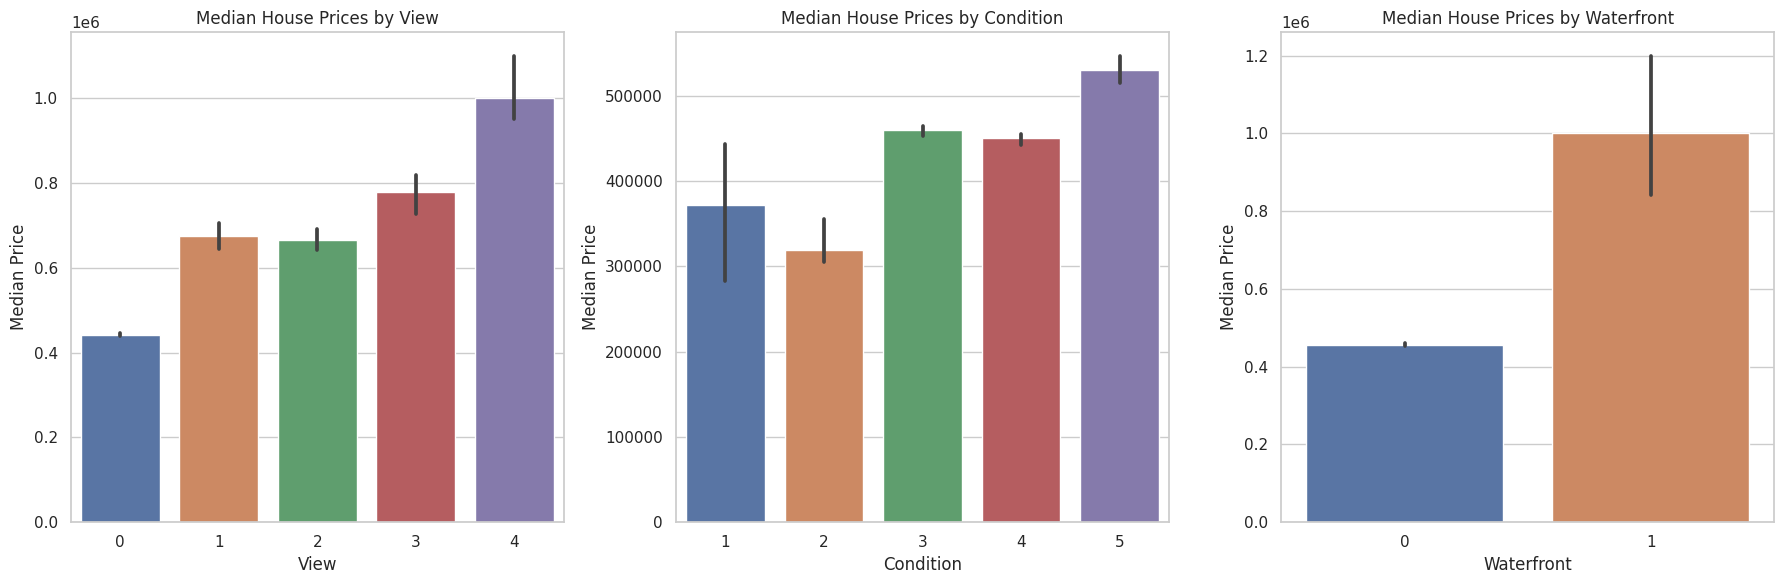

In [ ]:
sns.set(style="whitegrid")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x='view', y='price', data=df, estimator=np.median, ax=ax1)
ax1.set_title('Median House Prices by View')
ax1.set_xlabel('View')
ax1.set_ylabel('Median Price')

sns.barplot(x='condition', y='price', data=df, estimator=np.median, ax=ax2)
ax2.set_title('Median House Prices by Condition')
ax2.set_xlabel('Condition')
ax2.set_ylabel('Median Price')

sns.barplot(x='waterfront', y='price', data=df, estimator=np.median, ax=ax3)
ax3.set_title('Median House Prices by Waterfront')
ax3.set_xlabel('Waterfront')
ax3.set_ylabel('Median Price')

plt.tight_layout()

plt.show()

**Figure 1.4**

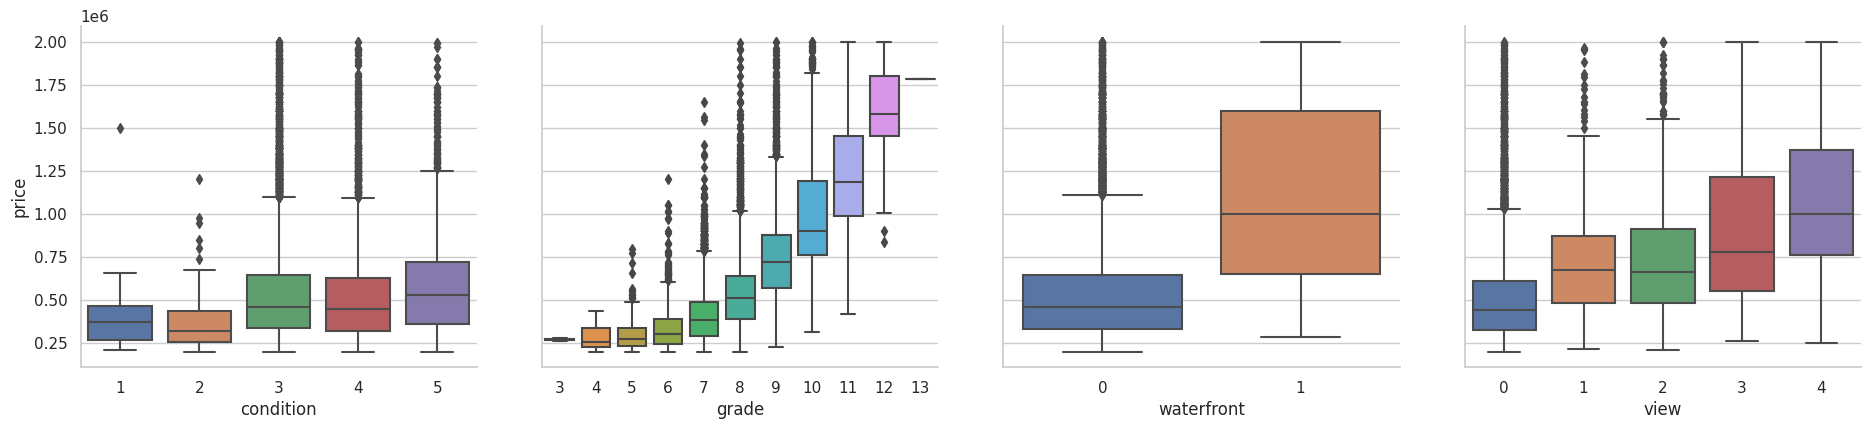

In [ ]:
value_indicators_box = sns.PairGrid(df,
                 x_vars=['condition', 'grade', 'waterfront', 'view'], y_vars=['price'])
value_indicators_box.fig.set_size_inches(20, 5)
value_indicators_box.map(sns.boxplot)


**Heatmap:** helps show correlation between variables in the data set.

0.00 to 0.19: Very weak correlation

0.20 to 0.39: Weak correlation

0.40 to 0.59: Moderate correlation

0.60 to 0.79: Strong correlation

0.80 to 1.00: Very strong correlation

**Figure 1.5**

<ipython-input-14-f30aebc8883b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1)


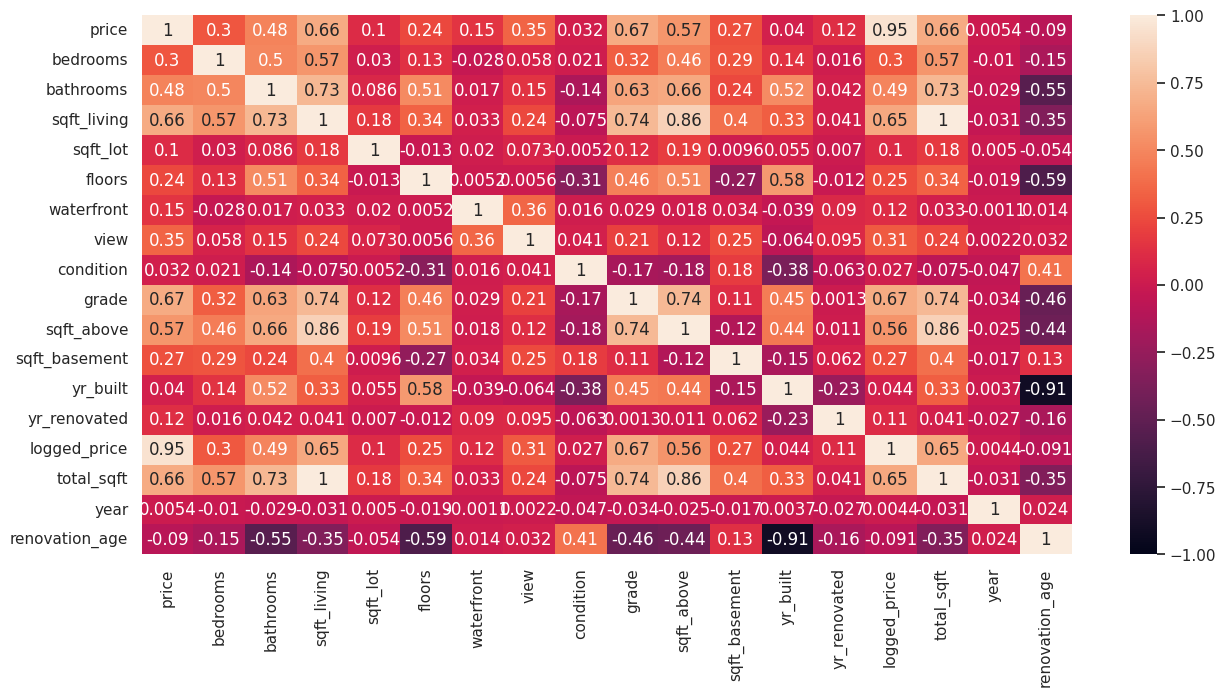

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1)
plt.show()

Deleting highly correlated and not needed values to avoid Multicollinearity and overfitting of the dataset

**Multicollinearity:** occurs when two or more independent variables in the model are strongly correlated with each other. This correlation can lead to challenges in interpreting the individual contributions of each variable to the model.

In [ ]:
df.drop(['sqft_above', 'sqft_basement', 'date', 'yr_renovated', 'yr_built', 'sqft_living', 'logged_price'], axis=1, inplace=True)

df_encoded.drop(['sqft_above', 'sqft_basement', 'sqft_living', 'date','yr_renovated', 'yr_built', 'logged_price'], axis=1, inplace=True)

df.head(5)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,zipcode,total_sqft,year,month,renovation_age
0,221900,3,1.00,5650,1,0,0,3,7,98178,1180,2014,10,59
1,538000,3,2.25,7242,2,0,0,3,7,98125,2570,2014,12,23
3,604000,4,3.00,5000,1,0,0,5,7,98136,1960,2014,12,49
4,510000,3,2.00,8080,1,0,0,3,8,98074,1680,2015,2,28
5,1225000,4,4.50,101930,1,0,0,3,11,98053,5420,2014,5,13


**Figure 1.6**

<ipython-input-16-f30aebc8883b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1)


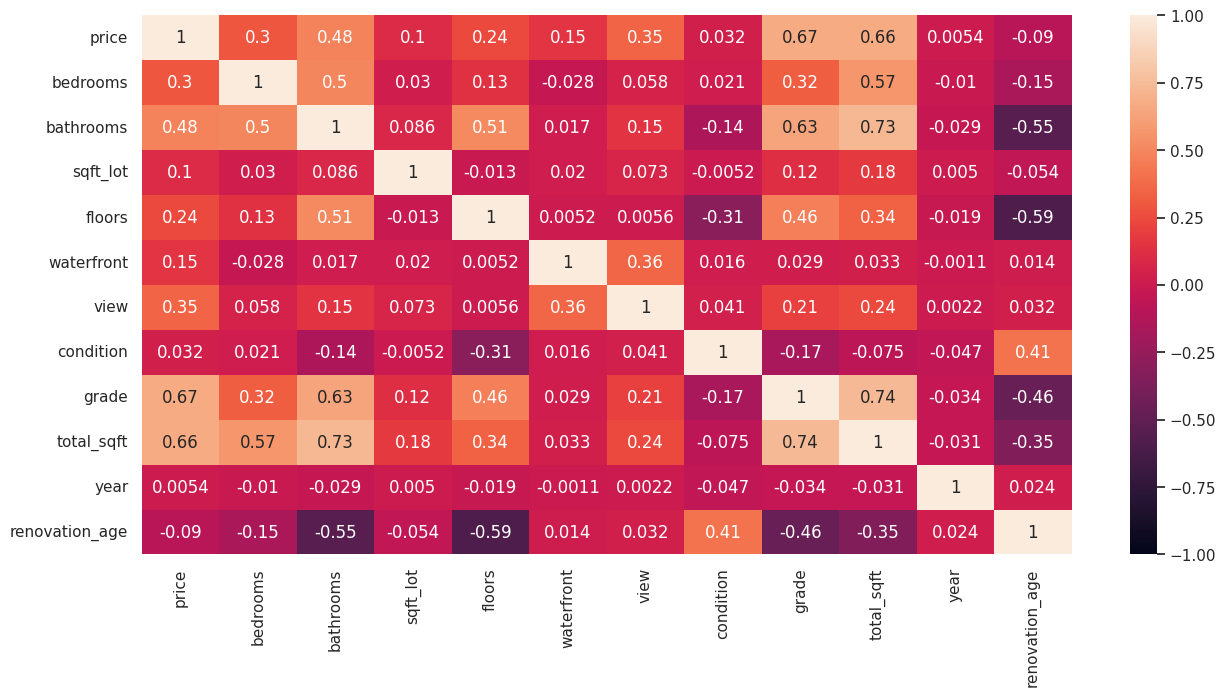

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(df.corr(),annot=True,vmax=1,vmin=-1)
plt.show()

In [ ]:
df['year_month'] = df.apply(lambda row: f"{row['year']}.{int(row['month']):02d}" if not np.isnan(row['month']) else np.nan, axis=1)
df = df.sort_values('year_month')

In [ ]:
m1 = df.groupby('year_month')['price'].median().reset_index()
m1.columns = ['year_month', 'median']
result_df = pd.merge(df, m1, on='year_month', how='left')

**Figure 1.7**

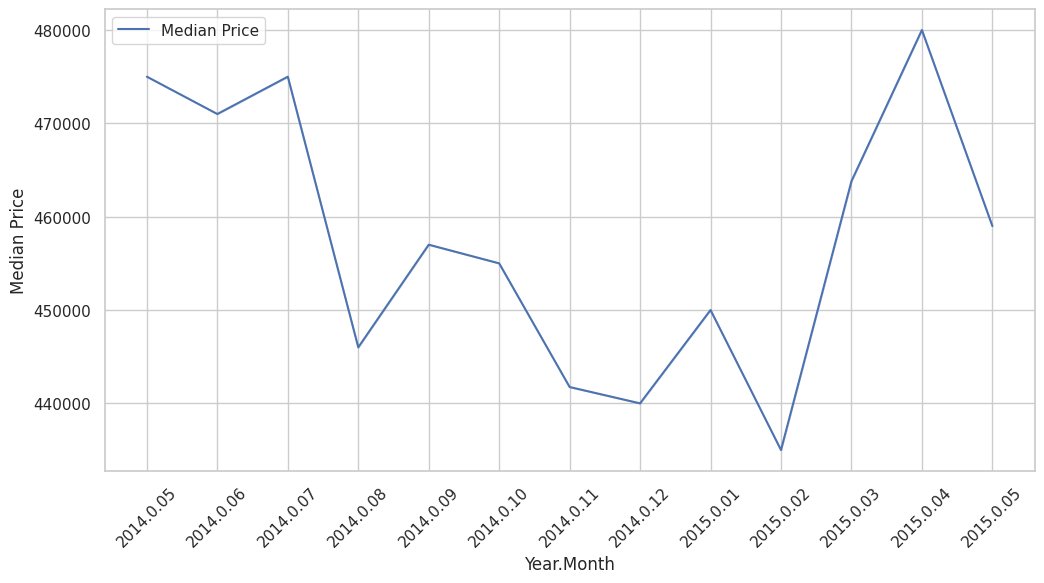

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='median', data=result_df, label='Median Price')
plt.xlabel('Year.Month')
plt.ylabel('Median Price')
plt.xticks(rotation=45)
plt.show()

In [ ]:
m = df.groupby('grade')['price'].median().reset_index()
m.columns = ['grade', 'median']
result_df_1 = pd.merge(df, m, on='grade', how='left')

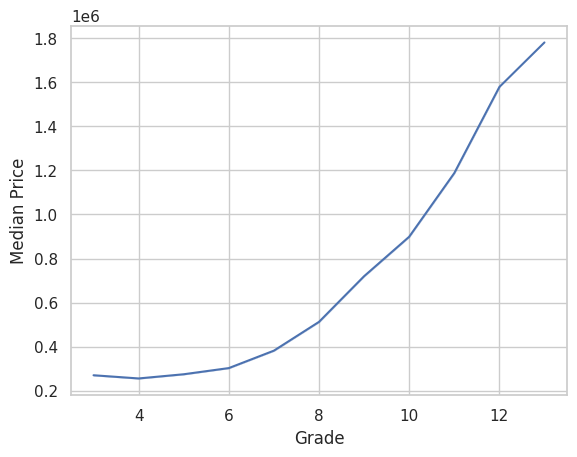

In [ ]:
sns.lineplot(data = result_df_1, x = "grade", y = "median")
plt.xlabel("Grade")
plt.ylabel("Median Price")
plt.show()

In [ ]:
m2 = df.groupby('total_sqft')['price'].median().reset_index()
m2.columns = ['total_sqft', 'median']
result_df_2 = pd.merge(df, m2, on='total_sqft', how='left')

**Figure 1.9**

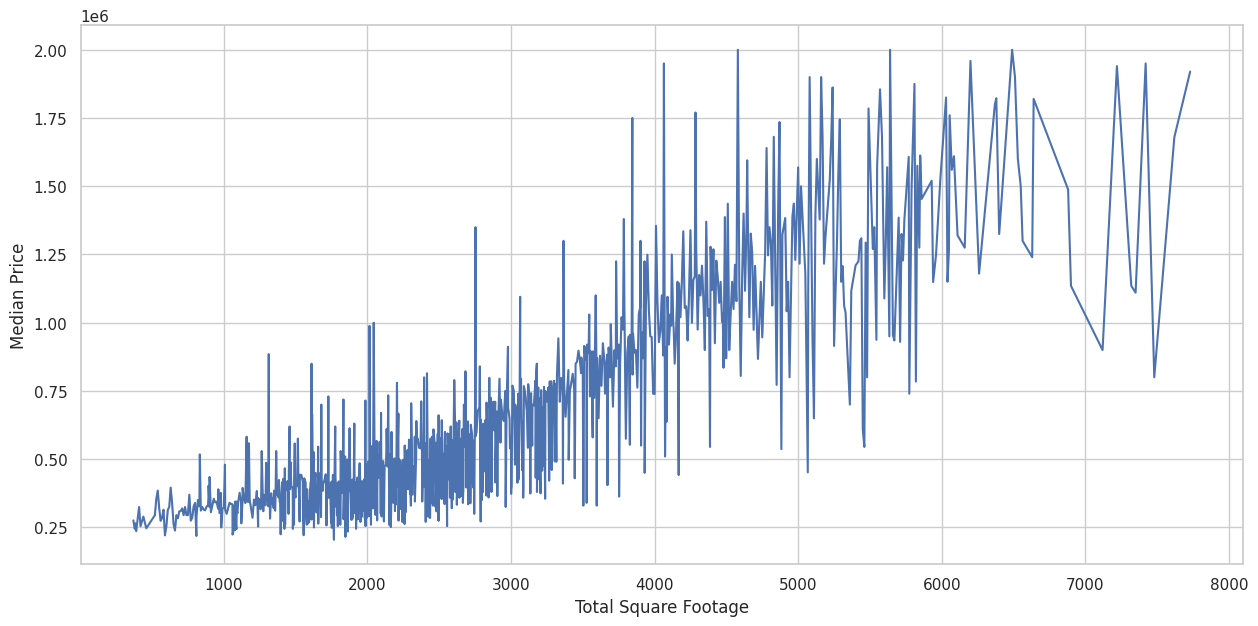

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(data = result_df_2, x = "total_sqft", y = "median")
plt.xlabel("Total Square Footage")
plt.ylabel("Median Price")
plt.show()

In [ ]:
m3 = df.groupby('bathrooms')['price'].median().reset_index()
m3.columns = ['bathrooms', 'median']
result_df_3 = pd.merge(df, m3, on='bathrooms', how='left')

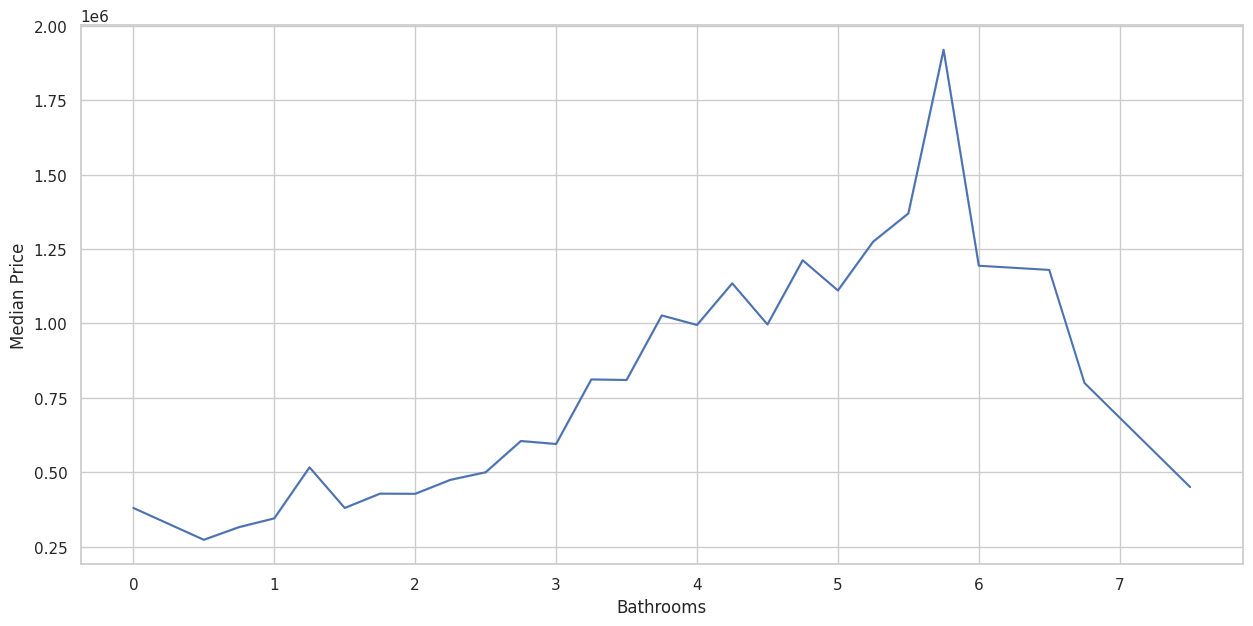

In [ ]:
plt.figure(figsize=(15,7))
sns.lineplot(data = result_df_3, x = "bathrooms", y = "median")
plt.xlabel("Bathrooms")
plt.ylabel("Median Price")
plt.show()

###**Machine Learning**

Comparing Linear regression vs. Gradient Boosting Regression

**Gradient Boosting Regression:** an ensemble machine learning technique that builds a predictive model by combining the predictions of multiple weak learners, typically decision trees, in a sequential and adaptive manner. Each new tree corrects the errors of the combined ensemble, leading to a powerful and accurate predictive model.

**Linear Regression:** a statistical method for modeling the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The goal is to find the best-fitting line (or hyperplane in higher dimensions) that minimizes the sum of squared differences between the predicted and actual values. It provides a simple and interpretable approach for regression tasks.

**Scoring Def**



*   **R Squared:** range from 0 to 1, where 0 indicates that the model does not explain any variance, and 1 indicates a perfect fit.
*   **Mean Squared Error:** calculated by taking the average of the squared differences between predicted and actual values. Lower MSE values indicate better model performance
*  **Cross Validation:** helps estimate how well a model will perform on new, unseen data. Involves splitting the dataset into multiple subsets, training the model on different combinations of training and validation sets, and evaluating its performance across these subsets


###**Linear Regression Model Fitting**

In [ ]:
model = LinearRegression()
X = df[['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
        'grade', 'zipcode', 'total_sqft', 'year', 'month','renovation_age']]
y = df ['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scores = cross_val_score(LinearRegression(), X_train_scaled, y_train, cv=5, scoring='r2')
model.fit(X_train_scaled, y_train)
prediction_reg = model.predict(X_test_scaled)
rmse_reg = mean_squared_error(y_test, prediction_reg, squared=False)
r2_reg = r2_score(y_test, prediction_reg)


print('Cross Validation Scores: ', scores)
print('Mean Squared Error: ', rmse_reg)
print('R-squared: ', r2_reg)

Cross Validation Scores:  [0.59700998 0.62429261 0.60840953 0.60679391 0.61115653]
Mean Squared Error:  178104.10884293175
R-squared:  0.5945671503518024


###**Gradient Boosting Regression Model Fitting**

Finding best hyperparameters for the Gradient Boosting Model using random search:

Random Search: randomly samples combinations of hyperparameter values from predefined ranges

n_estimators: The number of boosting stages or trees to be built.

learning_rate: The step size at each iteration while moving toward a minimum of the loss function.

max_depth: The maximum depth of the individual trees.

In [ ]:

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.05, 0.08, 0.1, 0.15],
    'max_depth': randint(3, 7)
}

gradient_model = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(gradient_model, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

best_params = random_search.best_params_
print('Best Parameters:', best_params)

"\nfrom scipy.stats import randint\nfrom sklearn.model_selection import RandomizedSearchCV\n\nparam_dist = {\n    'n_estimators': randint(100, 500), \n    'learning_rate': [0.05, 0.08, 0.1, 0.15], \n    'max_depth': randint(3, 7) \n}\n\ngradient_model = GradientBoostingRegressor(random_state=42)\nrandom_search = RandomizedSearchCV(gradient_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)\nrandom_search.fit(X_train_scaled, y_train)\n\nbest_params = random_search.best_params_\nprint('Best Parameters:', best_params)\n"

Best Paramters: {'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 393}

In [ ]:
gradient_model = GradientBoostingRegressor(n_estimators=393, learning_rate=0.15, max_depth=4, random_state=42)

scores = cross_val_score(gradient_model, X_train_scaled, y_train, cv=5, scoring='r2')
gradient_model.fit(X_train_scaled, y_train)
prediction_grad = gradient_model.predict(X_test_scaled)
rmse_grad = mean_squared_error(y_test, prediction_grad, squared=False)
r2_grad = r2_score(y_test, prediction_grad)

print('Cross Validation Scores: ', scores)
print('Mean Squared Error: ', rmse_grad)
print('R-squared: ', r2_grad)

Cross Validation Scores:  [0.87647262 0.88031495 0.87092533 0.86764039 0.86635256]
Mean Squared Error:  104697.25083025225
R-squared:  0.8598988782743252


**Homoscedasticity:** the spread or dispersion of the residuals remains consistent as the values of the predictor variable(s) change.

**Residuals:** differences between the observed (actual) values of the dependent variable and the values predicted by the regression model.

**Ground Truth:** the true or actual values of the target variable (the variable you are trying to predict) in a dataset

###**Linear Regression Model Testing**

**Figure 2.1**

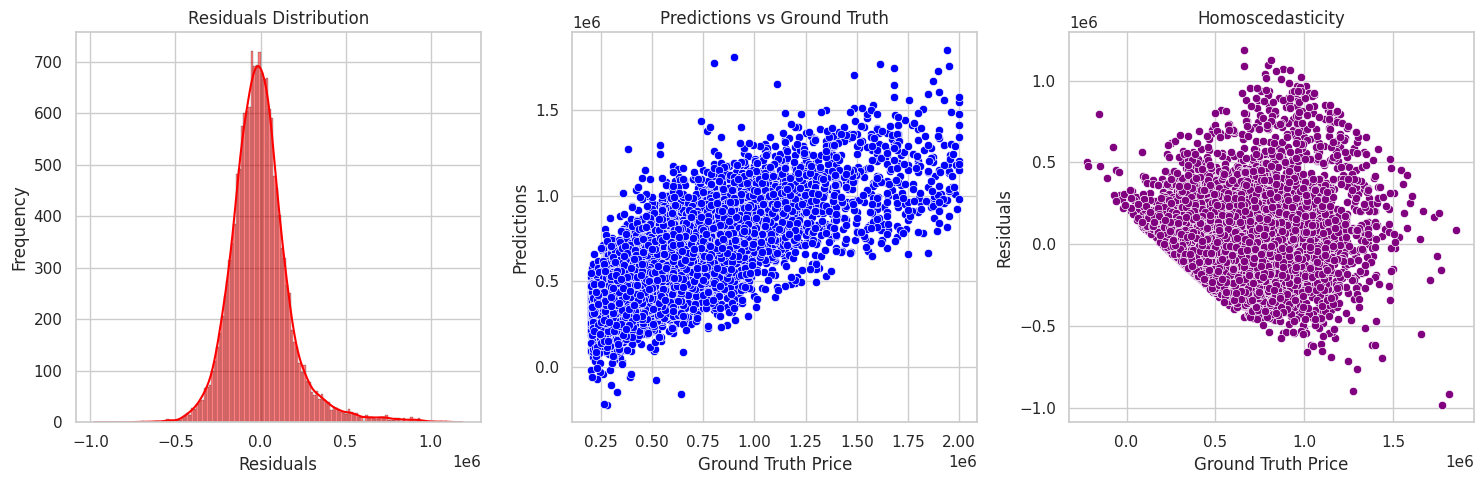

In [ ]:
y_pred_train = model.predict(X_train_scaled)
residuals = y_train - y_pred_train

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(residuals, color='red', edgecolor='black', kde=True, ax=ax1)
ax1.set_title('Residuals Distribution')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')

sns.scatterplot(x=y_train, y=y_pred_train, color='blue', ax=ax2)
ax2.set_title('Predictions vs Ground Truth')
ax2.set_xlabel('Ground Truth Price')
ax2.set_ylabel('Predictions')

sns.scatterplot(x=y_pred_train, y=residuals, color='purple', ax=ax3)
ax3.set_title('Homoscedasticity')
ax3.set_xlabel('Ground Truth Price')
ax3.set_ylabel('Residuals')

plt.tight_layout()

plt.show()


###**Gradient Boosting Regression Model Testing**

**Figure 2.2**

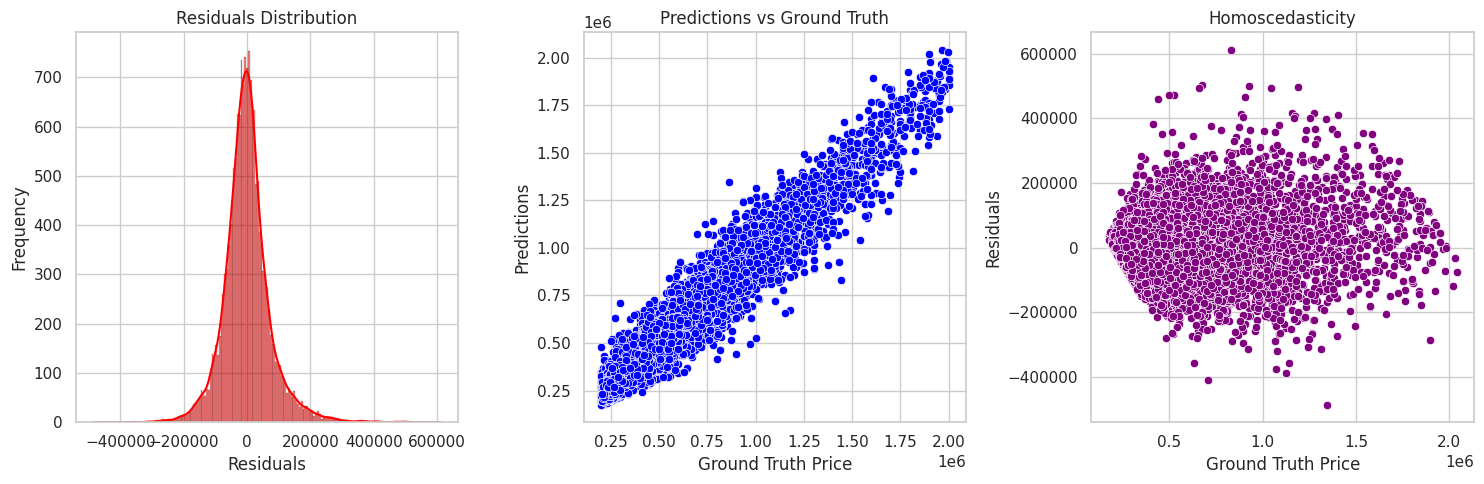

In [ ]:
y_pred_train_grad = gradient_model.predict(X_train_scaled)
residuals_grad = y_train - y_pred_train_grad

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(residuals_grad, color='red', edgecolor='black', kde=True, ax=ax1)
ax1.set_title('Residuals Distribution')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')

sns.scatterplot(x=y_train, y=y_pred_train_grad, color='blue', ax=ax2)
ax2.set_title('Predictions vs Ground Truth')
ax2.set_xlabel('Ground Truth Price')
ax2.set_ylabel('Predictions')

sns.scatterplot(x=y_pred_train_grad, y=residuals_grad, color='purple', ax=ax3)
ax3.set_title('Homoscedasticity')
ax3.set_xlabel('Ground Truth Price')
ax3.set_ylabel('Residuals')

plt.tight_layout()

plt.show()

###**Prediction Comparison Between Both Model**

**Figure 2.3**

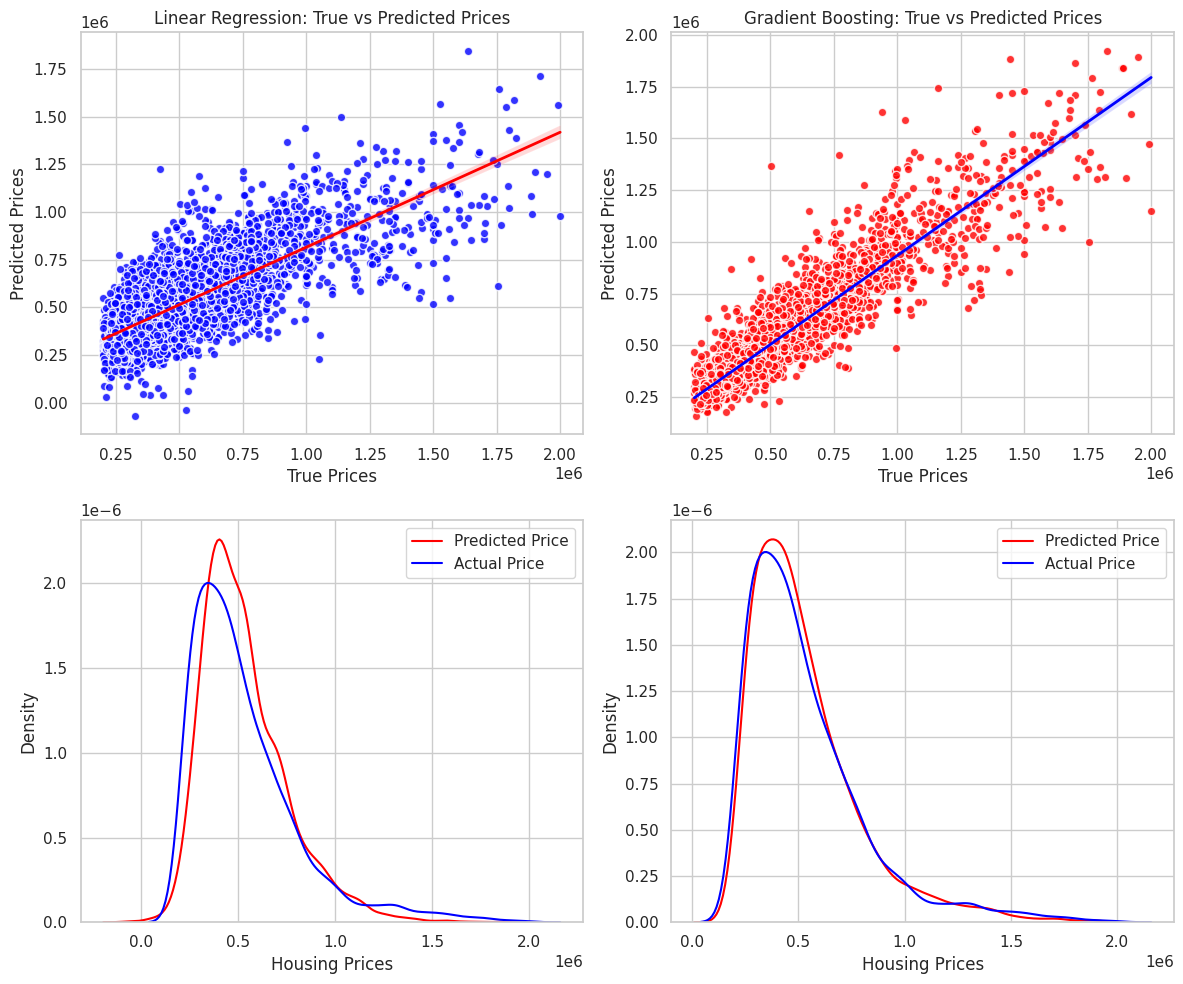

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 10))

sns.regplot(x=y_test, y=prediction_reg, data=df, color='blue',
            scatter_kws={'edgecolor': 'white'}, line_kws={'color': 'red', 'linewidth': 2}, ax=ax1[0])
ax1[0].set_xlabel('True Prices')
ax1[0].set_ylabel('Predicted Prices')
ax1[0].set_title('Linear Regression: True vs Predicted Prices')

sns.regplot(x=y_test, y=prediction_grad, data=df, color='red',
            scatter_kws={'edgecolor': 'white'}, line_kws={'color': 'blue', 'linewidth': 2}, ax=ax1[1])
ax1[1].set_xlabel('True Prices')
ax1[1].set_ylabel('Predicted Prices')
ax1[1].set_title('Gradient Boosting: True vs Predicted Prices')

sns.kdeplot(x=prediction_reg, color='red', label='Predicted Price', ax=ax2[0])
sns.kdeplot(x=y_test, color='blue', label='Actual Price', ax=ax2[0])
ax2[0].legend(['Predicted Price', 'Actual Price'])
ax2[0].set_xlabel('Housing Prices')
ax2[0].set_ylabel('Density')

sns.kdeplot(x=prediction_grad, color='red', label='Predicted Price', ax=ax2[1])
sns.kdeplot(x=y_test, color='blue', label='Actual Price', ax=ax2[1])
ax2[1].legend(['Predicted Price', 'Actual Price'])
ax2[1].set_xlabel('Housing Prices')
ax2[1].set_ylabel('Density')



plt.tight_layout()
plt.show()

###**Linear Regression With OneHotEncoding**

In [ ]:
model = LinearRegression()
X_encoded = df_encoded.loc[:, df_encoded.columns != 'price']
y_encoded = df_encoded ['price']

X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train_encoded)
X_test_encoded_scaled = scaler.transform(X_test_encoded)

scores = cross_val_score(LinearRegression(), X_train_encoded_scaled, y_train_encoded, cv=5, scoring='r2')
model.fit(X_train_encoded_scaled, y_train_encoded)
prediction_reg = model.predict(X_test_encoded_scaled)
rmse_reg = mean_squared_error(y_test_encoded, prediction_reg, squared=False)
r2_reg = r2_score(y_test_encoded, prediction_reg)


print('Cross Validation Scores: ', scores)
print('Mean Squared Error: ', rmse_reg)
print('R-squared: ', r2_reg)

Cross Validation Scores:  [ 6.01790589e-01  6.33280436e-01  6.21690511e-01  6.14833346e-01
 -1.97693211e+18]
Mean Squared Error:  176065.16074153618
R-squared:  0.6037968613773833


###**Gradient Boosting Regression With OneHotEncoding**

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': [0.05, 0.08, 0.1, 0.15],
    'max_depth': randint(3, 7)
}

gradient_model_encoded = GradientBoostingRegressor(random_state=42)
random_search_encoded = RandomizedSearchCV(gradient_model_encoded, param_distributions=param_dist, n_iter=10, cv=5, scoring='r2', random_state=42, n_jobs=-1)
random_search_encoded.fit(X_train_encoded_scaled, y_train_encoded)

best_params = random_search_encoded.best_params_
print('Best Parameters:', best_params)

Best Parameters: {'learning_rate': 0.08, 'max_depth': 6, 'n_estimators': 376}


Best Parameters: {'learning_rate': 0.08, 'max_depth': 6, 'n_estimators': 376}

In [ ]:
gradient_model = GradientBoostingRegressor(n_estimators=376, learning_rate=0.08, max_depth=6, random_state=42)

scores = cross_val_score(gradient_model, X_train_encoded_scaled, y_train_encoded, cv=5, scoring='r2')
gradient_model.fit(X_train_encoded_scaled, y_train_encoded)
prediction_grad = gradient_model.predict(X_test_encoded_scaled)
rmse_grad = mean_squared_error(y_test_encoded, prediction_grad, squared=False)
r2_grad = r2_score(y_test_encoded, prediction_grad)

print('Cross Validation Scores: ', scores)
print('Mean Squared Error: ', rmse_grad)
print('R-squared: ', r2_grad)

Cross Validation Scores:  [0.8682006  0.87089896 0.86406557 0.85925982 0.85828365]
Mean Squared Error:  105568.4780547311
R-squared:  0.8575575032171967


**Figure 2.4**

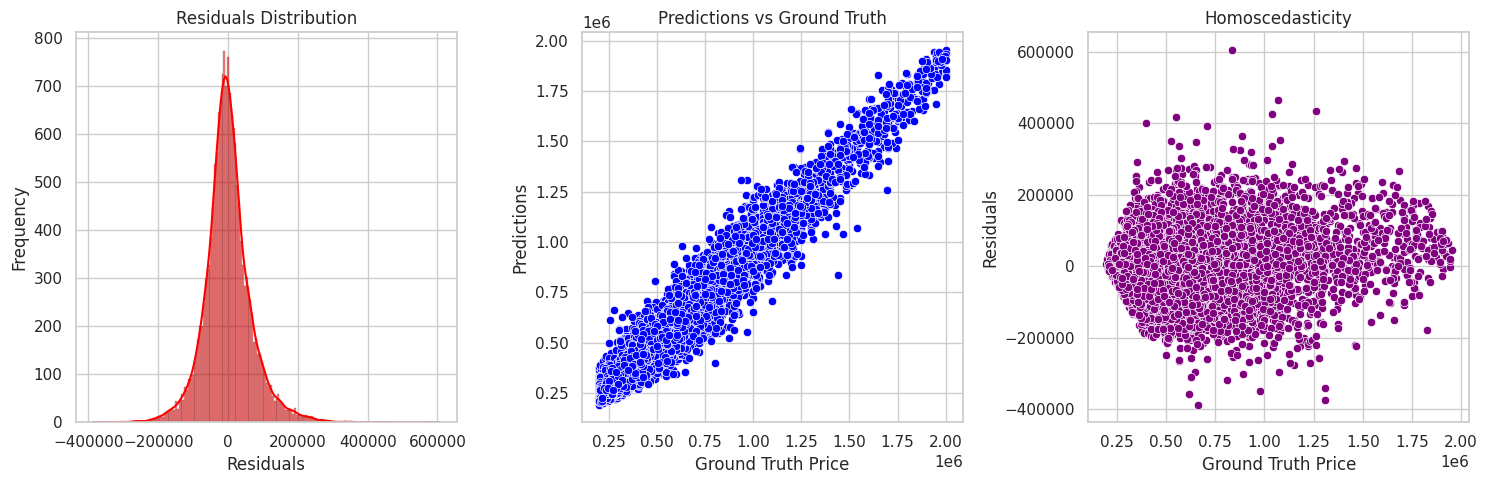

In [ ]:
y_pred_train_grad = gradient_model.predict(X_train_encoded_scaled)
residuals_grad = y_train_encoded - y_pred_train_grad

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))


sns.histplot(residuals_grad, color='red', edgecolor='black', kde=True, ax=ax1)
ax1.set_title('Residuals Distribution')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')

sns.scatterplot(x=y_train_encoded, y=y_pred_train_grad, color='blue', ax=ax2)
ax2.set_title('Predictions vs Ground Truth')
ax2.set_xlabel('Ground Truth Price')
ax2.set_ylabel('Predictions')

sns.scatterplot(x=y_pred_train_grad, y=residuals_grad, color='purple', ax=ax3)
ax3.set_title('Homoscedasticity')
ax3.set_xlabel('Ground Truth Price')
ax3.set_ylabel('Residuals')

plt.tight_layout()

plt.show()

**Figure 2.5**

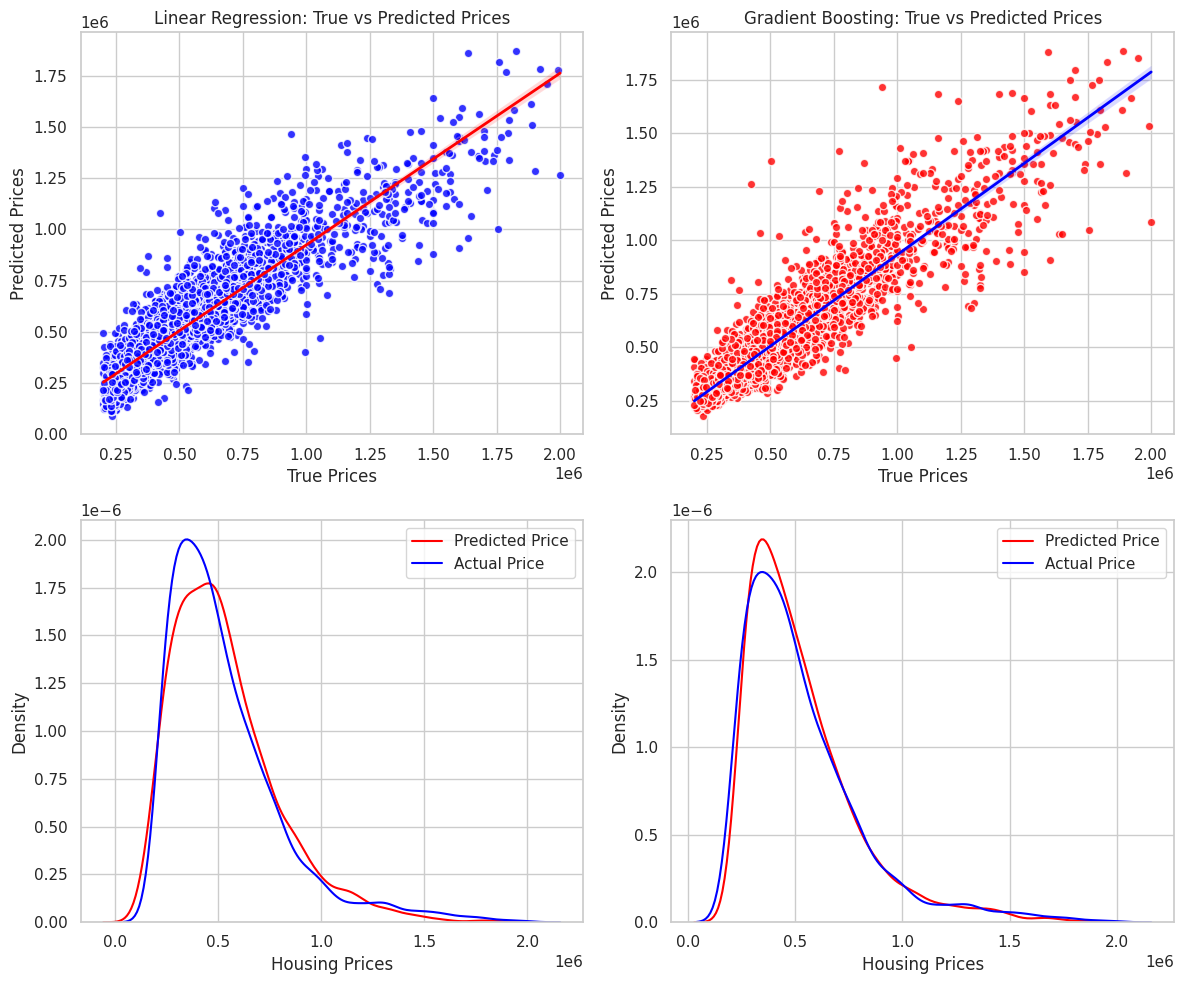

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 10))

sns.regplot(x=y_test_encoded, y=prediction_reg, data=df_encoded, color='blue',
            scatter_kws={'edgecolor': 'white'}, line_kws={'color': 'red', 'linewidth': 2}, ax=ax1[0])
ax1[0].set_xlabel('True Prices')
ax1[0].set_ylabel('Predicted Prices')
ax1[0].set_title('Linear Regression: True vs Predicted Prices')

sns.regplot(x=y_test_encoded, y=prediction_grad, data=df_encoded, color='red',
            scatter_kws={'edgecolor': 'white'}, line_kws={'color': 'blue', 'linewidth': 2}, ax=ax1[1])
ax1[1].set_xlabel('True Prices')
ax1[1].set_ylabel('Predicted Prices')
ax1[1].set_title('Gradient Boosting: True vs Predicted Prices')

sns.kdeplot(x=prediction_reg, color='red', label='Predicted Price', ax=ax2[0])
sns.kdeplot(x=y_test_encoded, color='blue', label='Actual Price', ax=ax2[0])
ax2[0].legend(['Predicted Price', 'Actual Price'])
ax2[0].set_xlabel('Housing Prices')
ax2[0].set_ylabel('Density')

sns.kdeplot(x=prediction_grad, color='red', label='Predicted Price', ax=ax2[1])
sns.kdeplot(x=y_test_encoded, color='blue', label='Actual Price', ax=ax2[1])
ax2[1].legend(['Predicted Price', 'Actual Price'])
ax2[1].set_xlabel('Housing Prices')
ax2[1].set_ylabel('Density')



plt.tight_layout()
plt.show()